In [1]:
!pip install fsspec gcsfs

     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 1.3MB 8.1MB/s 
     |████████████████████████████████| 296kB 12.7MB/s 
     |████████████████████████████████| 143kB 19.7MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=47fd3462dac9b60e63a1ddb6bceee6a219892a35006c2b5f91d9de722f4c66a9
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [2]:
import numpy as np 
import pandas as pd 


import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow import keras
from tensorflow.keras import applications as tl #transfer learning

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

try:
    from kaggle_datasets import KaggleDatasets
    dataset_gcs = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification')
    print('got GCS path via KaggleDatasets .get_gcs_path method')
except ModuleNotFoundError:
    #hardcode path while testing locally
    dataset_gcs = 'gs://kds-9254a9aba4b37289f07bbbbe4e2af5c952dd2d811a2c823340ca8091'

In [3]:
tf.__version__

'2.4.1'

In [4]:
params = {
    'batch_size' : 128,
    'img_size' : [512, 512], #length and width will be equal
    'epochs': 100
}

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

def start_tpu():
    '''function to initialize the TPU'''
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # strategy = tf.distribute.experimental.TPUStrategy(tpu)
if tpu:
    start_tpu()
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.35.185.82:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [6]:
train_df = pd.read_csv(dataset_gcs + '/train.csv')
train_df.groupby('label').count()


,image_id
label,
0,1087
1,2189
2,2386
3,13158
4,2577


In [7]:
def decode_image_train(tfrec):
    '''
    ***update documentation 
    function to decode an image from tfrecord
    
    args:
        tfrec: tfrecord, single record of training/validation data
    
    returns:
        decoded_image: tensor, converted image from tfrecord
        img_name: tensor, string, Id of the decoded image
    
    '''
    
    features_dictionary = {
        'image': tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64)
        }
    features = tf.io.parse_single_example(tfrec, features_dictionary)
    decoded_image = tf.io.decode_jpeg(features['image'], 3)
    decoded_image = tf.image.resize(decoded_image, params['img_size'])
#     img_name = features['image_name'] #I dont think I will need this
    target = features['target']
    
    return decoded_image, target #,img_name


In [8]:
def normalize_image(decoded_image, label):
    '''
    function to convert an image tensor values from 0 to 255 
    -> -1 to 1
    to be used when dealing with tfrecords containing labels
    
    args:
        decoded_image: tensor that is an image with values from 0 to 255
        label: tensor, target label
    
    returns: 
        image_tensor: tensor that is an image with values from -1 to 1
        label, same as input
    
    '''
    
    #add dim at the zero axis Shape will be from (x, y, z) -> (None, x, y, z)
    image_tensor = tf.expand_dims(decoded_image, 0)
    #undo the above line -- this is needed due to TF not allowing a filtered tensor py_function
    image_tensor = tf.gather(image_tensor, 0)

    #convert tensor values to between -1 and 1 (0 to 255 -> -1 to 1)
    image_tensor = (tf.cast(image_tensor, tf.float32) - 127.5) / 127.5

    return image_tensor, label

In [9]:
def random_flip(image, label):
    '''
    function to randomly flip images on the x and/or y axis
    
    args:
        image: tensor, an image
        label: tensor, target label
    
    returns: 
        image: tensor, same as input, but possibly flipped on x and/or y axis
        label, tensor, same as input
    '''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label


In [10]:
def one_hot(image, label):
    '''
    function to one hot encode label
    
    args:
        image: tensor, an image
        label: tensor, target label
        
    returns:
        image: tensor, same as input
        label: tensor, one hot encoded with a depth of 5
    '''
    label = tf.one_hot(label, 5)
    return image, label

In [11]:
def get_train_ds(tfrecords, batch_size):
    '''
    function to create a ds pipeline from tfrecord files
    
    args:
        tfrecords: list, tfrecord file paths
        batch_size: int, batch size for number of records to pass into
            model at a time
    returns:
        ds: tensorflow input pipeline with images and labels
    '''
    ds = (tf.data.TFRecordDataset(filenames=[tfrecords],
                                 num_parallel_reads=tf.data.experimental.AUTOTUNE).
          cache(). #need to remove cache while not usnig TPUs
          map(decode_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(random_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(one_hot, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          repeat().
          shuffle(512).
          batch(batch_size,
               drop_remainder=False).
          prefetch(tf.data.experimental.AUTOTUNE)
         )
    

    
    return ds

In [12]:
def get_ds_size(files):
    '''
    function to get size of tfrecord Dataset, based on file name
    
    the file name has the number of records in the file, for example:
    train09-2071.tfrec has 2017 records
    
    args:
        files: list of str file names, each item should be the path to a tfrecord file
    
    returns:
        size: int, size of dataset
    '''
    size = 0
    for file in files:
        file_size = int(file.split('.tfrec')[0].split('tfrecords/')[1].split('-')[1])
        size += file_size
    return size


In [13]:
#get train and validation file paths
train_files, valid_files = train_test_split(tf.io.gfile.glob(dataset_gcs + '/train_tfrecords/*.tfrec'),
                                            test_size=.1, random_state=1)
#create datasets
train_ds = get_train_ds(train_files, params['batch_size'])
valid_ds = get_train_ds(valid_files, params['batch_size'])

In [14]:
train_size, valid_size = get_ds_size(train_files), get_ds_size(valid_files)
print('the dataset consists of: {} training images, and {} validation images'.
     format(train_size, valid_size,))

the dataset consists of: 18721 training images, and 2676 validation images


In [15]:
epoch_steps = train_size // params['batch_size'] 
valid_steps = valid_size // params['batch_size']

In [16]:
targets = train_df.groupby('label').count()['image_id'].to_list()
#todo - consider using class weights

In [17]:
targets

[1087, 2189, 2386, 13158, 2577]

In [18]:
def create_model(pretrained_model,
                 pretrained_input_size,
                 dense_units=8,
                 input_shape=[*params['img_size'], 3]):
    '''
    function to create model
    '''
    input_tensor = layers.Input(shape=input_shape, name='images_input')
    
    resized = layers.experimental.preprocessing.Resizing(pretrained_input_size, 
                                                         pretrained_input_size)(input_tensor)
    pretrained_output = pretrained_model(include_top=False, classes=5, 
                                         input_shape=[pretrained_input_size, 
                                                      pretrained_input_size,3])(resized)
    end_of_pretrained_model = layers.GlobalAveragePooling2D()(pretrained_output)
    dense_layers = layers.Dense(dense_units)(end_of_pretrained_model)
    output = layers.Dense(5, activation='softmax')(dense_layers)
    model = keras.Model(inputs=input_tensor, outputs=output) 
    # model.layers[2].trainable = False
    
    metrics = [
        keras.metrics.CategoricalAccuracy(name='accuracy'),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.01),
        metrics=metrics)

    return model
    

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                patience=10,
                                mode='max',
                                restore_best_weights=True)

def lr_schedule_fn(epoch, lr):
    if epoch < 8:
        return 0.000001
    elif epoch == 8:
        return 0.0001 
    elif epoch %2 ==0 and epoch < 49:
        return lr * 0.75
    else:
        return lr
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule_fn)

def lr_schedule_fn_(epoch, lr):
    if epoch == 1:
        return 0.001 
    elif epoch %2 ==0 and epoch < 49:
        return lr * 0.75
    else:
        return lr
lr_schedule_ = tf.keras.callbacks.LearningRateScheduler(lr_schedule_fn_)



In [20]:
def training_procedure(model,
                       dataset=train_ds,
                       num_epochs=params['epochs'],
                       steps_epoch=epoch_steps,
                       valid_dataset=valid_ds,
                       valid_steps=valid_steps,
                       early_stopping=early_stopping,
                       schedule=lr_schedule,
                       verbose=1):
    '''
    function to train model
    #todo - work on documentation
    '''
    history = model.fit(dataset,
                        epochs=num_epochs,
                        steps_per_epoch=steps_epoch,
                        validation_data=valid_dataset,
                        validation_steps=valid_steps,
                        callbacks=[early_stopping, schedule],
                        verbose=verbose)
    return history


In [21]:
transfer_modeels = [tl.EfficientNetB1, tl.EfficientNetB2, tl.EfficientNetB3, #removed: tl.EfficientNetB0
                   tl.EfficientNetB4, tl.EfficientNetB5, tl.EfficientNetB6,]
input_sizes = [240, 260, 300, 380, 456, 528,] #removed: 224
# input_sizes = [456, 528, 600]
# transfer_modeels = [tl.EfficientNetB5, tl.EfficientNetB6, tl.EfficientNetB7]

transfer_models_sizes = zip(transfer_modeels, input_sizes)
# with strategy.scope():
model_dict = dict()
count = 0
for mdl, size in transfer_models_sizes:
    model_dict[count] = dict()
    with strategy.scope():
        model_dict[count]['model'] = create_model(pretrained_model=mdl,
                                                  pretrained_input_size=size)
    #     model_dict[count]['model'].summary()
    #     model_dict[count]['histor_'] = model_dict[count]['model'].fit(train_ds,
    #                                                                   epochs=params['epochs'],
    #                                                                   steps_per_epoch=epoch_steps,
    #                                                                   validation_data=valid_ds,
    #                                                                   validation_steps=valid_steps,
    # #                                                                       class_weights=class_weights,
    #                                                           callbacks=[early_stopping, lr_schedule_],
    #                                                           verbose=1)
    #     # model_dict[count]['untrainable_history'] = training_procedure(model_dict[count]['model'], schedule=lr_schedule_)
    #     model_dict[count]['model'].trainable = True
        model_dict[count]['model'].summary()
        model_dict[count]['history'] = model_dict[count]['model'].fit(train_ds,
                                                                      epochs=params['epochs'],
                                                                      steps_per_epoch=epoch_steps,
                                                                      validation_data=valid_ds,
                                                                      validation_steps=valid_steps,
    #                                                                       class_weights=class_weights,
                                                              callbacks=[early_stopping, lr_schedule],
                                                              verbose=1)
        # model_dict[count]['history'] = training_procedure(model_dict[count]['model'])
    model_path = 'model{}.h5'.format(count,)
    model_dict[count]['model'].save(model_path)
    model_dict[count]['max_accuracy'] = max(model_dict[count]['history'].history['val_accuracy'])
    tf.tpu.experimental.shutdown_tpu_system()
    start_tpu()
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    count +=1

27025408/27018416 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images_input (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 240, 240, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
Total params: 6,585,532
Trainable params: 6,523,477
Non-traina

INFO:tensorflow:Shutting down the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


31793152/31790344 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images_input (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 260, 260, 3)       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 9, 9, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 11272     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
Total params: 7,779,886
Trainable params: 7,712,311
Non-trai

INFO:tensorflow:Shutting down the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


43941888/43941136 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images_input (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
resizing_2 (Resizing)        (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 12296     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 45        
Total params: 10,795,876
Trainable params: 10,708,573
Non-tr

INFO:tensorflow:Shutting down the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


71688192/71686520 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images_input (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
resizing_3 (Resizing)        (None, 380, 380, 3)       0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 12, 12, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1792)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 14344     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 45        
Total params: 17,688,212
Trainable params: 17,563,005
Non-tr

INFO:tensorflow:Shutting down the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


115269632/115263384 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images_input (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
resizing_4 (Resizing)        (None, 456, 456, 3)       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 15, 15, 2048)      28513527  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 16392     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 45        
Total params: 28,529,964
Trainable params: 28,357,221
Non-

INFO:tensorflow:Shutting down the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


165240832/165234480 [==============================] - 2s 0us/step
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images_input (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
resizing_5 (Resizing)        (None, 528, 528, 3)       0         
_________________________________________________________________
efficientnetb6 (Functional)  (None, 17, 17, 2304)      40960143  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2304)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 18440     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 45        
Total params: 40,978,628
Trainable params: 40,754,189
Non-

INFO:tensorflow:Shutting down the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Finished shutting down TPU system.


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.185.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [22]:
def remove_last_model_layer(model, make_untrainable=False):
    '''
    removes last layer from a model, and optionally makes
    entire model untrainable
    '''
    input_layer = model.input
    output_layer = model.layers[-2].output
    # if make_untrainable == True:
    #     for layer in model.layers:
    #         layer.trainable = False
    new_model = keras.Model(input_layer, output_layer)
    new_model.trainable = False
    return new_model


In [23]:
for model in model_dict:
    model_path = 'model{}.h5'.format(model,)
    with strategy.scope():
        model_dict[model]['saved_model'] = tf.keras.models.load_model(model_path)
        model_dict[model]['model_no_last_layer'] = remove_last_model_layer(model_dict[model]['saved_model'])

In [24]:
model_dict

{0: {'history': <tensorflow.python.keras.callbacks.History at 0x7f8c41ef8080>,
  'max_accuracy': 0.821484386920929,
  'model': <tensorflow.python.keras.engine.functional.Functional at 0x7f8c41f35e80>,
  'model_no_last_layer': <tensorflow.python.keras.engine.functional.Functional at 0x7f8c104345f8>,
  'saved_model': <tensorflow.python.keras.engine.functional.Functional at 0x7f8c07c3ff60>},
 1: {'history': <tensorflow.python.keras.callbacks.History at 0x7f8c38c21860>,
  'max_accuracy': 0.823437511920929,
  'model': <tensorflow.python.keras.engine.functional.Functional at 0x7f8c38cd26d8>,
  'model_no_last_layer': <tensorflow.python.keras.engine.functional.Functional at 0x7f8c07739748>,
  'saved_model': <tensorflow.python.keras.engine.functional.Functional at 0x7f8c07090f98>},
 2: {'history': <tensorflow.python.keras.callbacks.History at 0x7f8c312d8748>,
  'max_accuracy': 0.83203125,
  'model': <tensorflow.python.keras.engine.functional.Functional at 0x7f8c30b35588>,
  'model_no_last_layer

In [26]:
with strategy.scope():
    input_layer = layers.Input((*params['img_size'],3))
    layers_to_concatenate = list()
    for model in model_dict:
        model_dict[model]['model_path'] = model_dict[model]['model_no_last_layer']((input_layer))
        model_dict[model]['model_path'] = layers.Dropout(0.3)(model_dict[model]['model_path'])
        layers_to_concatenate.append(model_dict[model]['model_path'])
    x = layers.Concatenate()(layers_to_concatenate)
    x = layers.Dense(128, activation='tanh')(x)
    x = layers.Dense(5, activation='softmax')(x)
    combined_model = keras.Model([input_layer], x)
    metrics = [
        keras.metrics.CategoricalAccuracy(name='accuracy'),]
    combined_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.01),
        metrics=metrics)
    

In [27]:
combined_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 8)            6585487     input_8[0][0]                    
__________________________________________________________________________________________________
model_7 (Functional)            (None, 8)            7779841     input_8[0][0]                    
__________________________________________________________________________________________________
model_8 (Functional)            (None, 8)            10795831    input_8[0][0]                    
___________________________________________________________________________________________

In [28]:
history = combined_model.fit(train_ds,
                            epochs=params['epochs'],
                            steps_per_epoch=epoch_steps,
                            validation_data=valid_ds,
                            validation_steps=valid_steps,
                            callbacks=[early_stopping, lr_schedule],
                             #consdier adding class weights
                            verbose=1)

Epoch 1/100
146/146 [==============================] - 331s 1s/step - loss: 1.8162 - accuracy: 0.2276 - val_loss: 1.6727 - val_accuracy: 0.1945
Epoch 2/100
146/146 [==============================] - 111s 757ms/step - loss: 1.7686 - accuracy: 0.2426 - val_loss: 1.6271 - val_accuracy: 0.2324
Epoch 3/100
146/146 [==============================] - 111s 758ms/step - loss: 1.7257 - accuracy: 0.2664 - val_loss: 1.5739 - val_accuracy: 0.2785
Epoch 4/100
146/146 [==============================] - 111s 761ms/step - loss: 1.6717 - accuracy: 0.2814 - val_loss: 1.5282 - val_accuracy: 0.2980
Epoch 5/100
146/146 [==============================] - 111s 759ms/step - loss: 1.6310 - accuracy: 0.3071 - val_loss: 1.4801 - val_accuracy: 0.3391
Epoch 6/100
146/146 [==============================] - 111s 759ms/step - loss: 1.5891 - accuracy: 0.3343 - val_loss: 1.4583 - val_accuracy: 0.3883
Epoch 7/100
146/146 [==============================] - 111s 759ms/step - loss: 1.5663 - accuracy: 0.3425 - val_loss: 1.40

In [29]:
def plot_metric(history, metric1, metric2, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()


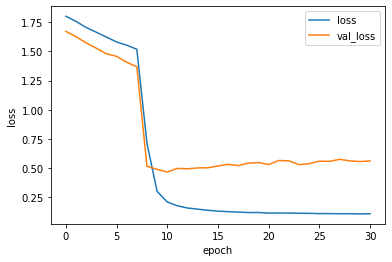

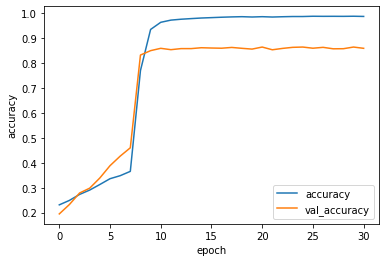

In [30]:
plot_metric(history, 'loss', 'val_loss', 'loss')
plot_metric(history, 'accuracy', 'val_accuracy', 'accuracy')

In [31]:
combined_model.save('final_model.h5')

In [34]:
combined_model.save_weights('final_weights')